In [38]:
import numpy as np
import datetime as dt
import tensorflow as tf
import time
import os
import math
import matplotlib.pyplot as plt
from sklearn.utils import shuffle

%matplotlib inline

In [65]:
# Import whole N-MNIST Dataset
def load_NMNIST(path):
    """
    """
    xs_train = []
    ys_train = []
    xs_test = []
    ys_test = []

    for class_index in range(0, 10):
        for (root, dirs, dat_files) in os.walk('{0}/n_Train_3/{1}'.format(path, str(class_index))):
            for file in dat_files:
                single_X = np.fromfile('{0}/n_Train_3/{1}/{2}'.format(path, str(class_index), file), dtype=np.int32)
                xs_train.append(single_X)
                ys_train.append(class_index)

        for (root, dirs, dat_files) in os.walk('{0}/n_Test_3/{1}'.format(path, str(class_index))):
            for file in dat_files:
                xs_test.append(np.fromfile('{0}/n_Test_3/{1}/{2}'.format(path, str(class_index), file), dtype=np.int32))
                ys_test.append(class_index)

    Xtr = np.array(xs_train)
    Ytr = np.array(ys_train)
    Xte = np.array(xs_test)
    Yte = np.array(ys_test)

    return Xtr, Ytr, Xte, Yte

In [71]:
dataset_class_path = '/Users/brunocalogero/Desktop/LowPowerActionRecognition/CNN/NMNIST/datasets'
X_train, Y_train, X_test, Y_test = load_NMNIST(dataset_class_path)

In [72]:
# As a sanity check, we print out the size of the training and test data.
print('Training data shape: ', X_train.shape)
print('Training labels shape: ', Y_train.shape)
print('Test data shape: ', X_test.shape)
print('Test labels shape: ', Y_test.shape)

# # shuffle the examples and their respective labels (training) 
X_train, Y_train = shuffle(X_train, Y_train, random_state=0)
X_test, Y_test = shuffle(X_test, Y_test, random_state=0)

Training data shape:  (60000, 2312)
Training labels shape:  (60000,)
Test data shape:  (10000, 2312)
Test labels shape:  (10000,)


In [74]:
# turn X training values into (60000, 34, 34, 2)
X_trainy = X_train.reshape(60000, 34, 34, 2)
# turn X test values into (10000, 34, 34, 2)
X_testy = X_test.reshape(10000, 34, 34, 2)


# As a sanity check, we print out the size of the training and test data.
print('Training data shape: ', X_trainy.shape)
print('Training labels shape: ', Y_train.shape)
print('Test data shape: ', X_testy.shape)
print('Test labels shape: ', Y_test.shape)

Training data shape:  (60000, 34, 34, 2)
Training labels shape:  (60000,)
Test data shape:  (10000, 34, 34, 2)
Test labels shape:  (10000,)


3


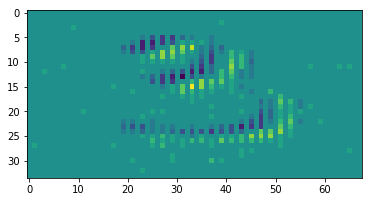

In [76]:
# quick sanity check to make sure our data looks like what we want as a 2D array, thus meaning our 34x34x2 is correct
print(Y_train[1])
plt.imshow(X_trainy[1].reshape(34,68))

In [77]:
# hesitant about the shuffleness around here
num_training = 59000
num_validation = 1000
num_test = 10000

mask = range(num_training, num_training + num_validation)
X_val = X_trainy[mask]
y_val = Y_train[mask]
mask = range(num_training)
X_trainy = X_trainy[mask]
Y_train = Y_train[mask]
mask = range(num_test)
X_testy = X_testy[mask]
Y_test = Y_test[mask]

# As a sanity check, we print out the size of the training and test data.
print('Training data shape: ', X_trainy.shape)
print('Test data shape: ', X_testy.shape)
print('Validation data shape: ', X_val.shape)

Training data shape:  (59000, 34, 34, 2)
Test data shape:  (10000, 34, 34, 2)
Validation data shape:  (1000, 34, 34, 2)


In [78]:
class Dataset(object):
    def __init__(self, X, y, batch_size, shuffle=False):
        """
        Construct a Dataset object to iterate over data X and labels y
        
        Inputs:
        - X: Numpy array of data, of any shape
        - y: Numpy array of labels, of any shape but with y.shape[0] == X.shape[0]
        - batch_size: Integer giving number of elements per minibatch
        - shuffle: (optional) Boolean, whether to shuffle the data on each epoch
        """
        assert X.shape[0] == y.shape[0], 'Got different numbers of data and labels'
        self.X, self.y = X, y
        self.batch_size, self.shuffle = batch_size, shuffle

    def __iter__(self):
        N, B = self.X.shape[0], self.batch_size
        idxs = np.arange(N)
        if self.shuffle:
            np.random.shuffle(idxs)
        return iter((self.X[i:i+B], self.y[i:i+B]) for i in range(0, N, B))


train_dset = Dataset(X_trainy, Y_train, batch_size=64, shuffle=True)
val_dset = Dataset(X_val, y_val, batch_size=64, shuffle=False)
test_dset = Dataset(X_testy, Y_test, batch_size=64)

In [79]:
print(train_dset)

In [80]:
# Set up some global variables
USE_GPU = False

if USE_GPU:
    device = '/device:GPU:0'
else:
    device = '/cpu:0'

# Constant to control how often we print when training models
print_every = 100

print('Using device: ', device)

Using device:  /cpu:0


In [81]:
def check_accuracy(sess, dset, x, scores, is_training=None):
    """
    Check accuracy on a classification model.
    
    Inputs:
    - sess: A TensorFlow Session that will be used to run the graph
    - dset: A Dataset object on which to check accuracy
    - x: A TensorFlow placeholder Tensor where input images should be fed
    - scores: A TensorFlow Tensor representing the scores output from the
      model; this is the Tensor we will ask TensorFlow to evaluate.
      
    Returns: Nothing, but prints the accuracy of the model
    """
    num_correct, num_samples = 0, 0
    for x_batch, y_batch in dset:
        feed_dict = {x: x_batch, is_training: 0}
        scores_np = sess.run(scores, feed_dict=feed_dict)
        y_pred = scores_np.argmax(axis=1)
        num_samples += x_batch.shape[0]
        num_correct += (y_pred == y_batch).sum()
    acc = float(num_correct) / num_samples
    print('Got %d / %d correct (%.2f%%)' % (num_correct, num_samples, 100 * acc))

In [83]:
def model_init_fn(inputs):
    channel_1, channel_2, channel_3, num_classes =  64, 32, 16, 10
    # consider using initializer for conv layers (variance scaling)
    
    conv1 = tf.layers.conv2d(inputs, channel_1, (3, 3), padding='SAME', activation=tf.nn.leaky_relu)
    bn1 = tf.layers.batch_normalization(conv1)
    pool1 = tf.layers.max_pooling2d(bn1, 2, 2)
    
    # maybe add a dropout at some point here
    
    conv2 = tf.layers.conv2d(pool1, channel_2, (3, 3), padding='SAME', activation=tf.nn.leaky_relu)
    bn2 = tf.layers.batch_normalization(conv2)
    pool2 = tf.layers.max_pooling2d(bn2, 2, 2)
    
    conv3 = tf.layers.conv2d(pool2, channel_3, (3, 3), padding='SAME', activation=tf.nn.leaky_relu)
    bn3 = tf.layers.batch_normalization(conv3)
    pool3 = tf.layers.max_pooling2d(bn3, 2, 2)
    
    conv3_flattened = tf.layers.flatten(pool3)
    fc = tf.layers.dense(conv3_flattened, num_classes)
    return fc


learning_rate = 0.001 
tf.reset_default_graph()
with tf.device(device):
    x = tf.placeholder(tf.float32, [None, 34, 34, 2])
    y = tf.placeholder(tf.int32, [None])
    is_training = tf.placeholder(tf.bool, name='is_training')
    
    scores = model_init_fn(x)
    loss   = tf.nn.sparse_softmax_cross_entropy_with_logits(labels=y, logits=scores)
    loss   = tf.reduce_mean(loss)
    
    optimizer = tf.train.AdamOptimizer(learning_rate)
    update_ops = tf.get_collection(tf.GraphKeys.UPDATE_OPS)
    with tf.control_dependencies(update_ops):
        train_op = optimizer.minimize(loss)
        
print_every = 2
num_epochs = 20 
with tf.Session() as sess:
    sess.run(tf.global_variables_initializer())
    t = 0
    for epoch in range(num_epochs):
        print('Starting epoch %d' % epoch)
        for x_np, y_np in train_dset:
            feed_dict = {x: x_np, y: y_np, is_training:1}
            loss_np, _ = sess.run([loss, train_op], feed_dict=feed_dict)
            if t % print_every == 0:
                print('Iteration %d, loss = %.4f' % (t, loss_np))
                check_accuracy(sess, val_dset, x, scores, is_training=is_training)
                print()
            t += 1

Starting epoch 0
Iteration 0, loss = 2.2928
Got 99 / 1000 correct (9.90%)

Iteration 2, loss = 2.2322
Got 207 / 1000 correct (20.70%)

Iteration 4, loss = 2.2028
Got 264 / 1000 correct (26.40%)

Iteration 6, loss = 2.2250
Got 263 / 1000 correct (26.30%)

Iteration 8, loss = 2.1508
Got 310 / 1000 correct (31.00%)

Iteration 10, loss = 2.1063
Got 346 / 1000 correct (34.60%)

Iteration 12, loss = 2.0168
Got 364 / 1000 correct (36.40%)

Iteration 14, loss = 2.0253
Got 404 / 1000 correct (40.40%)

Iteration 16, loss = 1.9284
Got 431 / 1000 correct (43.10%)

Iteration 18, loss = 1.8439
Got 454 / 1000 correct (45.40%)

Iteration 20, loss = 1.6899
Got 485 / 1000 correct (48.50%)

Iteration 22, loss = 1.6353
Got 477 / 1000 correct (47.70%)

Iteration 24, loss = 1.6876
Got 486 / 1000 correct (48.60%)

Iteration 26, loss = 1.6687
Got 548 / 1000 correct (54.80%)

Iteration 28, loss = 1.4961
Got 563 / 1000 correct (56.30%)

Iteration 30, loss = 1.4384
Got 570 / 1000 correct (57.00%)

Iteration 32, 

Iteration 266, loss = 0.2008
Got 922 / 1000 correct (92.20%)

Iteration 268, loss = 0.3955
Got 923 / 1000 correct (92.30%)

Iteration 270, loss = 0.2475
Got 940 / 1000 correct (94.00%)

Iteration 272, loss = 0.3070
Got 937 / 1000 correct (93.70%)

Iteration 274, loss = 0.2235
Got 930 / 1000 correct (93.00%)

Iteration 276, loss = 0.3247
Got 929 / 1000 correct (92.90%)

Iteration 278, loss = 0.2902
Got 939 / 1000 correct (93.90%)

Iteration 280, loss = 0.3675
Got 947 / 1000 correct (94.70%)

Iteration 282, loss = 0.1844
Got 941 / 1000 correct (94.10%)

Iteration 284, loss = 0.2128
Got 944 / 1000 correct (94.40%)

Iteration 286, loss = 0.2048
Got 946 / 1000 correct (94.60%)

Iteration 288, loss = 0.1844
Got 945 / 1000 correct (94.50%)

Iteration 290, loss = 0.1738
Got 943 / 1000 correct (94.30%)

Iteration 292, loss = 0.2777
Got 944 / 1000 correct (94.40%)

Iteration 294, loss = 0.1820
Got 944 / 1000 correct (94.40%)

Iteration 296, loss = 0.2470
Got 946 / 1000 correct (94.60%)

Iteratio

Got 958 / 1000 correct (95.80%)

Iteration 532, loss = 0.0634
Got 959 / 1000 correct (95.90%)

Iteration 534, loss = 0.1982
Got 959 / 1000 correct (95.90%)

Iteration 536, loss = 0.1952
Got 954 / 1000 correct (95.40%)

Iteration 538, loss = 0.1404
Got 948 / 1000 correct (94.80%)

Iteration 540, loss = 0.2065
Got 942 / 1000 correct (94.20%)

Iteration 542, loss = 0.1816
Got 942 / 1000 correct (94.20%)

Iteration 544, loss = 0.2344
Got 944 / 1000 correct (94.40%)

Iteration 546, loss = 0.1992
Got 948 / 1000 correct (94.80%)

Iteration 548, loss = 0.2556
Got 949 / 1000 correct (94.90%)

Iteration 550, loss = 0.2095
Got 954 / 1000 correct (95.40%)

Iteration 552, loss = 0.1304
Got 951 / 1000 correct (95.10%)

Iteration 554, loss = 0.1674
Got 955 / 1000 correct (95.50%)

Iteration 556, loss = 0.0644
Got 957 / 1000 correct (95.70%)

Iteration 558, loss = 0.2994
Got 959 / 1000 correct (95.90%)

Iteration 560, loss = 0.3073
Got 960 / 1000 correct (96.00%)

Iteration 562, loss = 0.2599
Got 962 

Iteration 796, loss = 0.2893
Got 946 / 1000 correct (94.60%)

Iteration 798, loss = 0.1468
Got 955 / 1000 correct (95.50%)

Iteration 800, loss = 0.1718
Got 958 / 1000 correct (95.80%)

Iteration 802, loss = 0.1095
Got 960 / 1000 correct (96.00%)

Iteration 804, loss = 0.0602
Got 964 / 1000 correct (96.40%)

Iteration 806, loss = 0.1295
Got 964 / 1000 correct (96.40%)

Iteration 808, loss = 0.1123
Got 961 / 1000 correct (96.10%)

Iteration 810, loss = 0.1608
Got 960 / 1000 correct (96.00%)

Iteration 812, loss = 0.0950
Got 962 / 1000 correct (96.20%)

Iteration 814, loss = 0.1181
Got 961 / 1000 correct (96.10%)

Iteration 816, loss = 0.1363
Got 962 / 1000 correct (96.20%)

Iteration 818, loss = 0.1823
Got 963 / 1000 correct (96.30%)

Iteration 820, loss = 0.1310
Got 960 / 1000 correct (96.00%)

Iteration 822, loss = 0.1394
Got 958 / 1000 correct (95.80%)

Iteration 824, loss = 0.1791
Got 963 / 1000 correct (96.30%)

Iteration 826, loss = 0.0955
Got 963 / 1000 correct (96.30%)

Iteratio

Got 968 / 1000 correct (96.80%)

Iteration 1060, loss = 0.2478
Got 966 / 1000 correct (96.60%)

Iteration 1062, loss = 0.1572
Got 967 / 1000 correct (96.70%)

Iteration 1064, loss = 0.1489
Got 965 / 1000 correct (96.50%)

Iteration 1066, loss = 0.1188
Got 966 / 1000 correct (96.60%)

Iteration 1068, loss = 0.0986
Got 969 / 1000 correct (96.90%)

Iteration 1070, loss = 0.1266
Got 970 / 1000 correct (97.00%)

Iteration 1072, loss = 0.1983
Got 971 / 1000 correct (97.10%)

Iteration 1074, loss = 0.1026
Got 968 / 1000 correct (96.80%)

Iteration 1076, loss = 0.2978
Got 970 / 1000 correct (97.00%)

Iteration 1078, loss = 0.0508
Got 968 / 1000 correct (96.80%)

Iteration 1080, loss = 0.1636
Got 965 / 1000 correct (96.50%)

Iteration 1082, loss = 0.0272
Got 967 / 1000 correct (96.70%)

Iteration 1084, loss = 0.0967
Got 969 / 1000 correct (96.90%)

Iteration 1086, loss = 0.0534
Got 958 / 1000 correct (95.80%)

Iteration 1088, loss = 0.0946
Got 959 / 1000 correct (95.90%)

Iteration 1090, loss =

Iteration 1320, loss = 0.1427
Got 956 / 1000 correct (95.60%)

Iteration 1322, loss = 0.3429
Got 957 / 1000 correct (95.70%)

Iteration 1324, loss = 0.1071
Got 961 / 1000 correct (96.10%)

Iteration 1326, loss = 0.0391
Got 963 / 1000 correct (96.30%)

Iteration 1328, loss = 0.0578
Got 962 / 1000 correct (96.20%)

Iteration 1330, loss = 0.0973
Got 963 / 1000 correct (96.30%)

Iteration 1332, loss = 0.1845
Got 963 / 1000 correct (96.30%)

Iteration 1334, loss = 0.1073
Got 965 / 1000 correct (96.50%)

Iteration 1336, loss = 0.2202
Got 963 / 1000 correct (96.30%)

Iteration 1338, loss = 0.1257
Got 962 / 1000 correct (96.20%)

Iteration 1340, loss = 0.1006
Got 965 / 1000 correct (96.50%)

Iteration 1342, loss = 0.2183
Got 966 / 1000 correct (96.60%)

Iteration 1344, loss = 0.0920
Got 969 / 1000 correct (96.90%)

Iteration 1346, loss = 0.1398
Got 967 / 1000 correct (96.70%)

Iteration 1348, loss = 0.0368
Got 966 / 1000 correct (96.60%)

Iteration 1350, loss = 0.0442
Got 965 / 1000 correct (9

Got 965 / 1000 correct (96.50%)

Iteration 1582, loss = 0.2179
Got 965 / 1000 correct (96.50%)

Iteration 1584, loss = 0.3254
Got 967 / 1000 correct (96.70%)

Iteration 1586, loss = 0.1015
Got 966 / 1000 correct (96.60%)

Iteration 1588, loss = 0.1324
Got 971 / 1000 correct (97.10%)

Iteration 1590, loss = 0.1858
Got 975 / 1000 correct (97.50%)

Iteration 1592, loss = 0.2450
Got 977 / 1000 correct (97.70%)

Iteration 1594, loss = 0.1149
Got 974 / 1000 correct (97.40%)

Iteration 1596, loss = 0.0984
Got 972 / 1000 correct (97.20%)

Iteration 1598, loss = 0.0468
Got 971 / 1000 correct (97.10%)

Iteration 1600, loss = 0.0869
Got 971 / 1000 correct (97.10%)

Iteration 1602, loss = 0.2722
Got 973 / 1000 correct (97.30%)

Iteration 1604, loss = 0.1176
Got 976 / 1000 correct (97.60%)

Iteration 1606, loss = 0.1055
Got 978 / 1000 correct (97.80%)

Iteration 1608, loss = 0.0406
Got 978 / 1000 correct (97.80%)

Iteration 1610, loss = 0.0671
Got 977 / 1000 correct (97.70%)

Iteration 1612, loss =

KeyboardInterrupt: 

In [13]:
def model_init_fn(inputs):
    # Network architecture: (conv -> relu -> batchnorm -> maxpool) * 2 -> FC
    conv1 = tf.layers.conv2d(inputs, 32, (3, 3), padding='SAME', activation=tf.nn.relu)
    bn1 = tf.layers.batch_normalization(conv1)
    pool1 = tf.layers.max_pooling2d(bn1, 2, 2)
    
    conv2 = tf.layers.conv2d(pool1, 64, (3, 3), padding='SAME', activation=tf.nn.relu)
    bn2 = tf.layers.batch_normalization(conv2)
    pool2 = tf.layers.max_pooling2d(bn2, 2, 2)
    
    conv2_flattened = tf.layers.flatten(pool2)
    
    fc = tf.layers.dense(conv2_flattened, 10)
    
    return fc


learning_rate = 5e-4
num_epoch = 10
tf.reset_default_graph()
with tf.device(device):
    is_training = tf.placeholder(tf.bool, name='is_training')
   
    # Set up placeholders for the data and labels
    x = tf.placeholder(tf.float32, [None, 34, 34, 2])
    y = tf.placeholder(tf.int32, [None])
    
    scores = model_init_fn(x)
    
    # Loss and optimization
    loss = tf.reduce_mean(tf.nn.sparse_softmax_cross_entropy_with_logits(labels=y, logits=scores))
   
    optimizer = tf.train.AdamOptimizer(learning_rate=learning_rate)
    update_ops = tf.get_collection(tf.GraphKeys.UPDATE_OPS)
    with tf.control_dependencies(update_ops):
        train_step = optimizer.minimize(loss)




# Now we actually run the graph many times using the training data
with tf.Session() as sess:
    # Initialize variables that will live in the graph
    sess.run(tf.global_variables_initializer())
    for i in range(num_epoch):
      for t, (x_np, y_np) in enumerate(train_dset):
          # Run the graph on a batch of training data; recall that asking
          # TensorFlow to evaluate loss will cause an SGD step to happen.
          feed_dict = {x: x_np, y: y_np, is_training:1}
          loss_np, _ = sess.run([loss, train_step], feed_dict=feed_dict)

      print('Epoch %d, loss = %.4f' % (i, loss_np))
      check_accuracy(sess, val_dset, x, scores, is_training)

Epoch 0, loss = 0.0052
Got 1000 / 1000 correct (100.00%)
Epoch 1, loss = 0.0080
Got 1000 / 1000 correct (100.00%)
Epoch 2, loss = 0.0106
Got 1000 / 1000 correct (100.00%)
Epoch 3, loss = 0.0002
Got 1000 / 1000 correct (100.00%)
Epoch 4, loss = 0.0004
Got 1000 / 1000 correct (100.00%)
Epoch 5, loss = 0.0071
Got 1000 / 1000 correct (100.00%)


KeyboardInterrupt: 